# Train DL

> Deep neural nets for PSSM

## Overview

**Utilities**

`seed_everything(seed=123)` — Sets random seeds across Python, NumPy, and PyTorch for reproducibility. Ensures deterministic behavior on CUDA.

```python
seed_everything(
    seed=42,  # random seed for reproducibility
)
```

`init_weights(m, leaky=0.)` — Applies Kaiming initialization to Conv layers. Pass to `model.apply()` for weight initialization.

```python
model = CNN1D(ni=1024, nf=230).apply(
    init_weights,  # initializes Conv layers with Kaiming normal
)
```

---

**Layer Builders**

`lin_wn(ni, nf, dp=0.1, act=nn.SiLU)` — Creates a weight-normalized linear layer with BatchNorm, Dropout, and activation.

```python
layer = lin_wn(
    ni=1024,       # input features
    nf=512,        # output features  
    dp=0.1,        # dropout probability
    act=nn.SiLU,   # activation function (None to disable)
)
```

`conv_wn(ni, nf, ks=3, stride=1, padding=1, dp=0.1, act=nn.ReLU)` — Creates a weight-normalized 1D convolution with BatchNorm, Dropout, and activation.

```python
layer = conv_wn(
    ni=256,        # input channels
    nf=512,        # output channels
    ks=5,          # kernel size
    stride=1,      # stride
    padding=2,     # padding
    dp=0.1,        # dropout probability
    act=nn.ReLU,   # activation function
)
```

---

**Models**

`MLP(num_features, num_targets, hidden_units=[512, 218], dp=0.2)` — Builds a multi-layer perceptron with BatchNorm and PReLU activations.

```python
model = MLP(
    num_features=1024,          # input dimension (e.g., T5 embeddings)
    num_targets=230,            # output dimension (23 AA × 10 positions)
    hidden_units=[512, 256],    # list of hidden layer sizes
    dp=0.2,                     # dropout rate (currently commented out)
)
```

`CNN1D(ni, nf, amp_scale=16)` — 1D CNN that amplifies input features, applies convolutions with skip connections, then projects to output.

```python
model = CNN1D(
    ni=1024,        # input features
    nf=230,         # output features (flattened PSSM)
    amp_scale=16,   # amplification factor for feature expansion
).apply(init_weights)
```

`PSSM_model(n_features, n_targets, model='MLP')` — Wrapper that reshapes flat output to `(batch, 23, positions)` PSSM format with softmax-ready logits.

```python
model = PSSM_model(
    n_features=1024,   # input feature dimension
    n_targets=230,     # total targets (must be divisible by 23)
    model='CNN',       # 'MLP' or 'CNN' architecture
)
# Output shape: (batch, 23, 10) for 10 positions
```

---

**Dataset**

`GeneralDataset(df, feat_col, target_col=None, A=23, dtype=np.float32)` — PyTorch Dataset that extracts features and reshapes targets to `(23, L)` PSSM matrices.

```python
ds = GeneralDataset(
    df=train_df,           # DataFrame with features and targets
    feat_col=feat_col,     # Index/list of feature column names
    target_col=target_col, # Index/list of target columns (None for test mode)
    A=23,                  # number of amino acids (including pS, pT, pY)
    dtype=np.float32,      # data type for tensors
)
# Returns (X, y) where y.shape = (23, L)
```

---

**Loss Function**

`CE(logits, target_probs)` — Cross-entropy loss with soft labels. Applies log_softmax to logits and computes against target probability distributions.

```python
loss = CE(
    logits=model_output,      # (B, 23, 10) raw logits
    target_probs=target_pssm, # (B, 23, 10) target probabilities (sum to 1 per position)
)
```

---

**Metrics**

`KLD(logits, target_probs)` — Kullback-Leibler divergence between target distribution (p) and predicted softmax distribution (q).

```python
kl_div = KLD(
    logits=model_output,      # (B, 23, 10) raw logits
    target_probs=target_pssm, # (B, 23, 10) target probabilities
)
```

`JSD(logits, target_probs)` — Jensen-Shannon divergence (symmetric metric) between target and predicted distributions.

```python
js_div = JSD(
    logits=model_output,      # (B, 23, 10) raw logits  
    target_probs=target_pssm, # (B, 23, 10) target probabilities
)
```

---

**Training**

`train_dl(df, feat_col, target_col, split, model_func, ...)` — Trains a model on a single train/valid split using fastai's `Learner` with one-cycle policy.

```python
target, pred = train_dl(
    df=df,                     # full DataFrame
    feat_col=feat_col,         # feature column names
    target_col=target_col,     # target column names
    split=split0,              # (train_idx, valid_idx) tuple
    model_func=get_cnn,        # callable returning fresh model
    n_epoch=10,                # number of training epochs
    bs=32,                     # batch size
    lr=3e-3,                   # learning rate
    loss=CE,                   # loss function
    save='my_model',           # save to models/my_model.pth
    sampler=None,              # optional custom sampler
    lr_find=True,              # run lr_find before training
)
# Returns (target_df, pred_df) for validation set
```

`train_dl_cv(df, feat_col, target_col, splits, model_func, save=None, **kwargs)` — Cross-validation wrapper that trains across multiple folds and concatenates OOF predictions.

```python
oof = train_dl_cv(
    df=df,                     # full DataFrame
    feat_col=feat_col,         # feature column names
    target_col=target_col,     # target column names
    splits=splits,             # list of (train_idx, valid_idx) tuples
    model_func=get_cnn,        # callable returning fresh model
    save='cnn',                # saves as cnn_fold0.pth, cnn_fold1.pth, ...
    n_epoch=10,                # passed to train_dl
    lr=3e-3,                   # passed to train_dl
)
# Returns DataFrame with all OOF predictions + 'nfold' column
```

---

**Prediction**

`predict_dl(df, feat_col, target_col, model_func, model_pth)` — Loads a saved model and generates predictions for a DataFrame.

```python
preds = predict_dl(
    df=test_df,                # DataFrame to predict
    feat_col=feat_col,         # feature column names
    target_col=target_col,     # used for output column names
    model_func=get_cnn,        # must match saved architecture
    model_pth='cnn_fold0',     # model name (without .pth)
)
# Returns DataFrame with softmax probabilities, same shape as target_col
```

## Setup

In [ ]:
#| default_exp dnn

In [ ]:
#| export
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import fastcore.all as fc

import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from katlas.pssm import *
from fastai.vision.all import *
import pandas as pd

## Utils

In [ ]:
#| export
def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
seed_everything()

In [ ]:
#| export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def_device

'mps'

## Load Data

In [ ]:
# df=pd.read_parquet('paper/kinase_domain/train/pspa_t5.parquet')

In [ ]:
# info=Data.get_kinase_info()

# info = info[info.pseudo=='0']

# info = info[info.kd_ID.notna()]

# subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']

# pspa_info = pd.DataFrame(df.index.tolist(),columns=['kinase'])

# pspa_info['subfamily'] = pspa_info.kinase.map(subfamily_map)

# splits = get_splits(pspa_info, group='subfamily',nfold=5)

# split0 = splits[0]

GroupKFold(n_splits=5, random_state=None, shuffle=False)
# subfamily in train set: 120
# subfamily in test set: 29


In [ ]:
# df=df.reset_index()

In [ ]:
# df.columns

Index(['index', '-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1255)

In [ ]:
# # column name of feature and target
# feat_col = df.columns[df.columns.str.startswith('T5_')]
# target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [ ]:
# feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

In [ ]:
# target_col

Index(['-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P', '4P',
       ...
       '-5pY', '-4pY', '-3pY', '-2pY', '-1pY', '0pY', '1pY', '2pY', '3pY',
       '4pY'],
      dtype='object', length=230)

## Dataset

In [ ]:
#| export
class GeneralDataset(Dataset):
    def __init__(self,
                 df,
                 feat_col,            # list/Index of feature columns (e.g., 100 cols)
                 target_col=None,     # list/Index of flattened PSSM cols; AA-first; A=23
                 A: int = 23,
                 dtype=np.float32):
        """
        If target_col is None -> test mode, returns only X.
        Otherwise returns (X, y) where y has shape (23, L), L inferred from target columns.
        """
        self.test = target_col is None
        self.aa = A

        # Features
        self.X = df[feat_col].to_numpy(dtype=dtype, copy=True)

        self.y = None
        if not self.test:
            y_flat = df[target_col].to_numpy(dtype=dtype, copy=True)

            total = y_flat.shape[1]
            if total % A != 0:
                raise ValueError(f"Target columns ({total}) not divisible by A={A}; cannot infer L.")
            self.position = total // self.aa

            # AA-first: reshape to (N, 23, L)
            self.y = y_flat.reshape(-1, A, self.position) # reshape from row-major flatten
            # if column-major as pandas.unstack is column major
            # self.y = y_flat.reshape(-1, self.position,self.aa).transpose(0, 2, 1) 

        self.len = len(df)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        X = torch.from_numpy(self.X[index])        # (feat_dim,)
        if self.test: return X
        y = torch.from_numpy(self.y[index])        # (23, L)
        return X, y

In [ ]:
# # dataset
# ds = GeneralDataset(df,feat_col,target_col)

In [ ]:
# len(ds)

368

In [ ]:
# dl = DataLoader(ds, batch_size=64, shuffle=True)

In [ ]:
# xb,yb = next(iter(dl))

# xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 10]))

## Models

### MLP

In [ ]:
#| export
def MLP(num_features, 
          num_targets,
          hidden_units = [512, 218],
          dp = 0.2):
    
    # Start with the first layer from num_features to the first hidden layer
    layers = [
        nn.Linear(num_features, hidden_units[0]),
        nn.BatchNorm1d(hidden_units[0]),
        # nn.Dropout(dp),
        nn.PReLU()
    ]
    
    # Loop over hidden units to create intermediate layers
    for i in range(len(hidden_units) - 1):
        layers.extend([
            nn.Linear(hidden_units[i], hidden_units[i+1]),
            nn.BatchNorm1d(hidden_units[i+1]),
            # nn.Dropout(dp),
            nn.PReLU()
        ])
    
    # Add the output layer
    layers.append(nn.Linear(hidden_units[-1], num_targets))
    
    model = nn.Sequential(*layers)
    
    return model

In [ ]:
# n_feature = len(feat_col)
# n_target = len(target_col)

In [ ]:
# model = MLP(n_feature, n_target)

In [ ]:
# model(xb)

tensor([[-0.6386,  0.6025, -0.5043,  ...,  0.4508,  0.6506,  0.4236],
        [ 0.6917, -0.3774,  0.4275,  ..., -0.2647, -0.5108,  0.2595],
        [ 0.0525,  0.5919, -0.6559,  ...,  0.2015,  0.1638, -0.0517],
        ...,
        [ 0.2075,  0.2489,  0.0794,  ...,  0.0141, -0.0182,  0.0464],
        [-0.2573,  0.9761, -1.6474,  ...,  0.5026,  0.4576,  0.5259],
        [-0.0075,  0.6411, -0.4033,  ...,  0.6004,  0.4007, -0.1181]],
       grad_fn=<AddmmBackward0>)

### CNN1D

In [ ]:
#| export
def init_weights(m, leaky=0.):
    "Initiate any Conv layer with Kaiming norm."
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): nn.init.kaiming_normal_(m.weight, a=leaky)

In [ ]:
#| export
def lin_wn(ni,nf,dp=0.1,act=nn.SiLU):
    "Weight norm of linear."
    layers =  nn.Sequential(
            nn.BatchNorm1d(ni),
            nn.Dropout(dp),
            nn.utils.parametrizations.weight_norm(nn.Linear(ni, nf)) )
    if act: layers.append(act())
    return layers

In [ ]:
#| export
def conv_wn(ni, nf, ks=3, stride=1, padding=1, dp=0.1,act=nn.ReLU):
    "Weight norm of conv."
    layers =  nn.Sequential(
        nn.BatchNorm1d(ni),
        nn.Dropout(dp),
        nn.utils.parametrizations.weight_norm(nn.Conv1d(ni, nf, ks, stride, padding)) )
    if act: layers.append(act())
    return layers

In [ ]:
#| export
class CNN1D(nn.Module):
    
    def __init__(self, ni, nf, amp_scale = 16):
        super().__init__()

        cha_1,cha_2,cha_3 = 256,512,512
        hidden_size = cha_1*amp_scale

        cha_po_1 = hidden_size//(cha_1*2)
        cha_po_2 = (hidden_size//(cha_1*4)) * cha_3
        
        self.lin = lin_wn(ni,hidden_size)
        
        # bs, 256, 16
        self.view = View(-1,cha_1,amp_scale)
        
        self.conv1 = nn.Sequential(
            conv_wn(cha_1, cha_2, ks=5, stride=1, padding=2, dp=0.1),
            nn.AdaptiveAvgPool1d(output_size = cha_po_1),
            conv_wn(cha_2, cha_2, ks=3, stride=1, padding=1, dp=0.1))
        
        self.conv2 = nn.Sequential(
            conv_wn(cha_2, cha_2, ks=3, stride=1, padding=1, dp=0.3),
            conv_wn(cha_2, cha_3, ks=5, stride=1, padding=2, dp=0.2))
        
        self.head = nn.Sequential(
            nn.MaxPool1d(kernel_size=4, stride=2, padding=1),
            nn.Flatten(),
            lin_wn(cha_po_2,nf,act=None) )


    def forward(self, x):
        # amplify features to 4096
        x = self.lin(x)
        
        # reshape to bs,256,16 for conv1d
        x = self.view(x) 

        x = self.conv1(x)
        
        x_s = x  # for skip connection (multiply)
        x = self.conv2(x)
        x = x * x_s

        # Final block
        x = self.head(x)

        return x

In [ ]:
# model = CNN1D(n_feature,n_target).apply(init_weights)

In [ ]:
# model(xb).shape

torch.Size([64, 230])

## Wrapper

In [ ]:
#| export
class PSSM_model(nn.Module):
    def __init__(self, 
                 n_features,
                 n_targets,
                 model='MLP'):
        super().__init__()
        self.n_features=n_features
        self.n_targets=n_targets
        self.n_aa = 23
        if self.n_targets % self.n_aa != 0: raise ValueError(f"n_targets ({n_targets}) must be divisible by n_aa ({n_aa}).")
        self.n_positions = self.n_targets//self.n_aa
        
        if model =='MLP': self.model=MLP(self.n_features, self.n_targets)
        elif model =='CNN': self.model=CNN1D(self.n_features, self.n_targets).apply(init_weights)
        else: raise ValueError('model must be MLP or CNN.')
    def forward(self,x):
        logits = self.model(x).reshape(-1, self.n_aa,self.n_positions)
        return logits

In [ ]:
# model = PSSM_model(n_feature,n_target)

In [ ]:
# logits= model(xb)

In [ ]:
# logits.shape

torch.Size([64, 23, 10])

In [ ]:
# def get_mlp(): return PSSM_model(n_feature,n_target,model='MLP')

# def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

## Loss

In [ ]:
#| export
def CE(logits: torch.Tensor,
       target_probs: torch.Tensor,
      ):
    """
    Cross-entropy with soft labels.
    logits:       (B, 20, 10)
    target_probs: (B, 20, 10), each column (over AA) sums to 1
    """
    logp = F.log_softmax(logits, dim=1)              # (B, 20, 10)
    ce   = -(target_probs * logp).sum(dim=1)         # (B, 10)
    return ce.mean()

In [ ]:
# CE(logits,yb)

tensor(3.2424, grad_fn=<MeanBackward0>)

## Metrics

In [ ]:
#| export
def KLD(logits: torch.Tensor,
          target_probs: torch.Tensor,
         ):
    """
    Averaged KL divergence across positions between target_probs (p) and softmax(logits) (q).
    
    logits:       (B, 20, 10)
    target_probs: (B, 20, 10), each column (over AA) sums to 1
    """
    logq = F.log_softmax(logits, dim=1)    # log q(x)
    logp = torch.log(target_probs + 1e-8) # log p(x), safe for zeros
    kl   = (target_probs * (logp - logq)).sum(dim=1)   # (B, 10)
    return kl.mean()

In [ ]:
# KLD(logits,yb)

tensor(0.5011, grad_fn=<MeanBackward0>)

In [ ]:
#| export
def JSD(logits: torch.Tensor,
        target_probs: torch.Tensor,
       ):
    """
    Averaged Jensen-Shannon Divergence across positions between target_probs (p) and softmax(logits) (q).

    logits:       (B, 20, 10)
    target_probs: (B, 20, 10), each column (over AA) sums to 1
    """
    # p, q distributions
    q = F.softmax(logits, dim=1)                # q(x)
    p = target_probs
    m = 0.5 * (p + q)                           # midpoint distribution

    # logs (with epsilon for stability)
    logp = torch.log(p + 1e-8)
    logq = torch.log(q + 1e-8)
    logm = torch.log(m + 1e-8)

    # KL(p||m) and KL(q||m)
    kld_pm = (p * (logp - logm)).sum(dim=1)
    kld_qm = (q * (logq - logm)).sum(dim=1)

    jsd = 0.5 * (kld_pm + kld_qm)               # (B, 10)
    return jsd.mean()

In [ ]:
# JSD(logits,yb)

tensor(0.1034, grad_fn=<MeanBackward0>)

## Trainer

In [ ]:
#| export
def train_dl(df, 
            feat_col, 
            target_col,
            split, # tuple of numpy array for split index
            model_func, # function to get pytorch model
             n_epoch = 4, # number of epochs
             bs = 32, # batch size
             lr = 1e-2, # will be useless if lr_find is True
            loss = CE, # loss function
            save = None, # models/{save}.pth
             sampler = None,
             lr_find=False, # if true, will use lr from lr_find
              ):
    "A DL trainer."
    
    train = df.loc[split[0]]
    valid = df.loc[split[1]]
    
    train_ds = GeneralDataset(train, feat_col, target_col)
    valid_ds = GeneralDataset(valid, feat_col, target_col)
    
    n_workers = fc.defaults.cpus

    dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=bs, num_workers=n_workers)

    model = model_func()
    learn = Learner(dls.to(def_device), model.to(def_device), loss, 
                    metrics= [KLD,JSD]
                    # cbs = [GradientClip(1.0)] # prevent overfitting
                   )
    
    if lr_find:
        # get learning rate
        lr = learn.lr_find()
        plt.show()
        plt.close()
        print(lr)

        
    print('lr in training is', lr)
    learn.fit_one_cycle(n_epoch,lr) #cbs = [SaveModelCallback(fname = 'best')] # save best model
    
    if save is not None:
        learn.save(save)
        
    pred,target = learn.get_preds()

    # row first
    pred  = F.softmax(pred, dim=1).reshape(len(valid),-1)
    target = target.reshape(len(valid),-1)

    # column first
    # pred  = F.softmax(pred, dim=1).permute(0, 2, 1).reshape(len(valid),-1)
    # target = target.permute(0, 2, 1).reshape(len(valid),-1)
    
    pred = pd.DataFrame(pred.detach().cpu().numpy(),index=valid.index,columns=target_col)
    target = pd.DataFrame(target.detach().cpu().numpy(),index=valid.index,columns=target_col)
    
    return target, pred

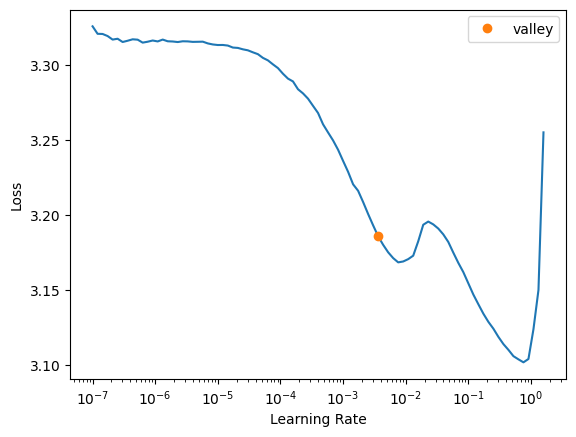

SuggestedLRs(valley=0.00363078061491251)
lr in training is SuggestedLRs(valley=0.00363078061491251)


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.147446,3.038438,0.318980,0.071486,00:00


In [ ]:
# target, pred = train_dl(df, 
#                         feat_col, 
#                         target_col,
#                         split0, 
#                         model_func=get_cnn,
#                         n_epoch=1,
#                         lr = 3e-3,
#                         lr_find=True,
#                         save = 'test')

In [ ]:
# pred

,-5P,-4P,-3P,-2P,-1P,0P,1P,2P,3P,4P,...,-5pY,-4pY,-3pY,-2pY,-1pY,0pY,1pY,2pY,3pY,4pY
14,0.051638,0.042721,0.047461,0.041219,0.033932,0.018915,0.077473,0.034604,0.045717,0.041970,...,0.036053,0.056273,0.031747,0.048270,0.061980,0.046331,0.054140,0.053547,0.048135,0.059772
15,0.051626,0.042801,0.047456,0.041166,0.034053,0.018975,0.077170,0.034668,0.045690,0.042009,...,0.035993,0.056192,0.031686,0.048179,0.061937,0.046108,0.053993,0.053433,0.048049,0.059777
16,0.051641,0.042793,0.047463,0.041167,0.034072,0.018973,0.077176,0.034652,0.045694,0.042008,...,0.035997,0.056190,0.031682,0.048167,0.061924,0.046074,0.053964,0.053437,0.048047,0.059765
36,0.051615,0.042611,0.047080,0.041040,0.034041,0.018777,0.077937,0.034638,0.045706,0.041972,...,0.036068,0.056490,0.031812,0.048282,0.062101,0.045894,0.054315,0.053463,0.048288,0.059904
37,0.051693,0.042929,0.047477,0.041184,0.034156,0.018997,0.077338,0.034726,0.045655,0.042012,...,0.035987,0.056114,0.031603,0.048077,0.061846,0.046072,0.053757,0.053384,0.047950,0.059570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,0.051463,0.042745,0.047294,0.041089,0.034083,0.019065,0.077317,0.034702,0.046079,0.042078,...,0.036065,0.056231,0.031961,0.048298,0.061863,0.047434,0.054065,0.053318,0.048310,0.059943
348,0.051470,0.042849,0.047324,0.041169,0.034008,0.019065,0.077173,0.034711,0.045994,0.042123,...,0.036031,0.056180,0.031971,0.048263,0.061977,0.047308,0.054164,0.053355,0.048320,0.059924
354,0.051433,0.042782,0.047271,0.041186,0.034024,0.019104,0.077271,0.034715,0.045971,0.042089,...,0.036032,0.056207,0.032021,0.048299,0.061972,0.047766,0.054218,0.053410,0.048319,0.059949
356,0.051309,0.042509,0.047054,0.041165,0.034242,0.019028,0.077537,0.034745,0.046062,0.042151,...,0.035995,0.056161,0.031950,0.048345,0.061846,0.047154,0.054128,0.053405,0.047976,0.059789


In [ ]:
# pred_pssm = recover_pssm(pred.iloc[0])
# pred_pssm.sum()

Position
-5    1.0
-4    1.0
-3    1.0
-2    1.0
-1    1.0
 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
dtype: float32

## Predict

In [ ]:
#| export
def predict_dl(df, 
               feat_col, 
               target_col,
               model_func, # model architecture
               model_pth, # only name, not with .pth
              ):
    
    "Predict dataframe given a deep learning model"
    
    test_dset = GeneralDataset(df,feat_col)
    test_dl = DataLoader(test_dset,bs=512)
    
    model = model_func()
    
    learn = Learner(None, model.to(def_device), loss_func=1)
    learn.load(model_pth,weights_only=False)
    
    learn.model.eval()
    
    preds = []
    for data in test_dl:
        inputs = data.to(def_device)
        pred = learn.model(inputs)

        pred  = F.softmax(pred, dim=1).reshape(len(pred),-1)
        # pred  = F.softmax(pred, dim=1).permute(0, 2, 1).reshape(len(pred),-1)

        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)
    preds = pd.DataFrame(preds,index=df.index,columns=target_col)

    return preds

In [ ]:
# test = df.loc[split0[1]].copy()

In [ ]:
# test_pred = predict_dl(test, 
#                feat_col, 
#                target_col,
#                model_func=get_cnn, # model architecture
#                model_pth='test', # only name, not with .pth
#               )

In [ ]:
# test_pred.columns

Index(['-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P', '4P',
       ...
       '-5pY', '-4pY', '-3pY', '-2pY', '-1pY', '0pY', '1pY', '2pY', '3pY',
       '4pY'],
      dtype='object', length=230)

In [ ]:
# pssm_pred = recover_pssm(test_pred.iloc[0])
# pssm_pred.sum()

Position
-5    1.0
-4    1.0
-3    1.0
-2    1.0
-1    1.0
 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
dtype: float32

<Axes: >

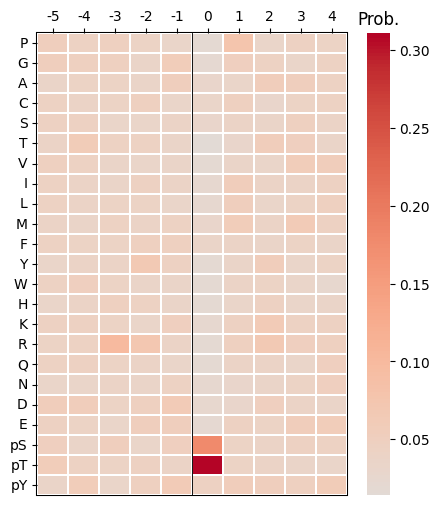

In [ ]:
# plot_heatmap(pssm_pred)

## CV train
> cross-validation

In [ ]:
#| export
def train_dl_cv(df, 
                feat_col, 
                target_col, 
                splits, # list of tuples
                model_func, # functions like lambda x: return MLP_1(num_feat, num_target)
                save:str=None,
                **kwargs
                ):
    
    OOF = []
    
    for fold,split in enumerate(splits):

        print(f'------fold{fold}------')
        
        fname = f'{save}_fold{fold}' if save is not None else None
        
        
        # train model
        target, pred = train_dl(df,feat_col,target_col, split, model_func ,save=fname,**kwargs)

        pred['nfold'] = fold
        OOF.append(pred)
        

    # Concatenate OOF from each fold to a new dataframe
    oofs = pd.concat(OOF).sort_index()
    
    return oofs

In [ ]:
# oof = train_dl_cv(df,feat_col,target_col,
#                   splits = splits,
#                   model_func = get_cnn,
#                   n_epoch=1,lr=3e-3,save='cnn')

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.136976,3.053134,0.333676,0.075223,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.116230,2.985299,0.230389,0.051941,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.126288,2.993812,0.241427,0.059246,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.097305,3.008505,0.245488,0.061335,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.120687,3.022246,0.272693,0.061717,00:00


In [ ]:
# oof.nfold.value_counts()

nfold
2    74
1    74
0    74
3    73
4    73
Name: count, dtype: int64

## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()